In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import yaml

from tqdm.notebook import tqdm

import pickle


In [2]:
from spine.utils.tracking import get_track_segments
from spine.utils.mcs import mcs_angles


Welcome to JupyROOT 6.26/16


In [3]:
from spine.driver import Driver


In [4]:
cfg_txt = '''
base:
  verbosity: warning
io:
  reader:
    name: hdf5
    file_keys: DATA_PATH
    skip_unknown_attrs: true
    
# Build reconstruction output representations
build:
  mode: both
  units: cm
  fragments: false
  particles: true
  interactions: true
'''


In [5]:
# downloaded from /pnfs/sbnd/persistent/users/mueller/MCP2025B/full_hdf5_test_files/mc5e18/*.h5
DATA_FILES = os.listdir('/nevis/riverside/data/leehagaman/spine/mc5e18')

log_file_location = '/nevis/houston/home/leehagaman/spine/mcs_studies/logs'

for file in os.listdir(log_file_location):
    os.remove(f'{log_file_location}/{file}')

num_files = 100

print(f"loading {num_files} / {len(DATA_FILES)} files")


true_contained = []
reco_contained = []
true_primary = []
reco_primary = []
true_start_point = []
reco_start_point = []
true_start_dir = []
reco_start_dir = []
truth_ke = []
reco_ke = []
reco_mcs_ke = []
reco_csda_ke = []
reco_calo_ke = []

reco_segment_dirs = []
reco_segment_angles = []

for file_i, DATA_FILE in tqdm(enumerate(DATA_FILES[:num_files]), total=num_files):

    DATA_PATH = f'/nevis/riverside/data/leehagaman/spine/mc5e18/{DATA_FILE}'
    #DATA_PATH = f'/nevis/riverside/data/leehagaman/spine/sbnd_medium_spine.h5'

    cfg = yaml.safe_load(cfg_txt.replace('DATA_PATH', DATA_PATH))
    driver = Driver(cfg)

    for ENTRY in range(len(driver)):
        data = driver.process(entry=ENTRY)

        for true_particle, reco_particle in data['particle_matches_t2r']:

            if abs(true_particle.pdg_code) != 13: # non-muon
                continue

            if not true_particle.is_matched: # no reco match
                continue

            reco_points = reco_particle.points

            segment_clusts, segment_dirs, segment_lengths = get_track_segments(reco_points, 14)
            segment_angles = mcs_angles(segment_dirs)

            reco_segment_dirs.append(segment_dirs)
            reco_segment_angles.append(segment_angles)
            
            true_contained.append(true_particle.is_contained)
            reco_contained.append(reco_particle.is_contained)
            
            true_primary.append(true_particle.is_primary)
            reco_primary.append(reco_particle.is_primary)

            true_start_point.append(true_particle.start_point)
            reco_start_point.append(reco_particle.start_point)

            true_start_dir.append(true_particle.start_dir)
            reco_start_dir.append(reco_particle.start_dir)

            truth_ke.append(true_particle.ke)
            reco_ke.append(reco_particle.ke)
            reco_mcs_ke.append(reco_particle.mcs_ke)
            reco_csda_ke.append(reco_particle.csda_ke)
            reco_calo_ke.append(reco_particle.calo_ke)


loading 100 / 480 files


  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
df = pd.DataFrame({
    'true_contained': true_contained,
    'reco_contained': reco_contained,
    'true_primary': true_primary,
    'reco_primary': reco_primary,
    'true_start_point': true_start_point,
    'reco_start_point': reco_start_point,
    'true_start_dir': true_start_dir,
    'reco_start_dir': reco_start_dir,
    'truth_ke': truth_ke,
    'reco_ke': reco_ke,
    'reco_mcs_ke': reco_mcs_ke,
    'reco_csda_ke': reco_csda_ke,
    'reco_calo_ke': reco_calo_ke,
    'reco_segment_dirs': reco_segment_dirs,
    'reco_segment_angles': reco_segment_angles})
df


,true_contained,reco_contained,true_primary,reco_primary,true_start_point,reco_start_point,true_start_dir,reco_start_dir,truth_ke,reco_ke,reco_mcs_ke,reco_csda_ke,reco_calo_ke,reco_segment_dirs,reco_segment_angles
0,False,False,True,True,"[-103.64998, 199.65, 97.54998]","[-103.65001, 199.65, 97.55001]","[0.23716806, -0.88699627, -0.39621842]","[0.23265445, -0.8944723, -0.38182622]",1861.997540,668.900475,668.900475,554.918016,499.182861,"[[-0.21378449, 0.8978953, 0.3848119], [-0.2141...","[0.04770872, 0.020754216, 0.086638644, 0.08803..."
1,False,False,True,True,"[49.049988, 198.15, 71.450005]","[165.15, -61.65001, 167.75]","[0.30311435, -0.9132014, 0.27236915]","[-0.45496294, 0.78865767, -0.4135551]",882.566387,663.089199,663.089199,693.382875,623.642761,"[[0.33988714, -0.89220434, 0.29740235], [0.366...","[0.06162004, 0.07328206, 8.4598745e-05, 0.0520..."
2,False,False,True,True,"[18.450012, 199.65, 166.55002]","[-33.450012, -81.45, 161.15]","[-0.19221635, -0.9813285, 0.006868543]","[0.17417416, 0.9826447, 0.06381908]",2997.528980,773.756516,773.756516,653.508615,593.887756,"[[0.17099041, 0.9831839, 0.06412249], [0.17098...","[3.525991e-06, 0.021244956, 0.000110554414, 0...."
3,False,False,True,True,"[-136.35, 198.15, 56.15]","[-137.25, 199.65, 57.050003]","[0.39617345, -0.9144244, -0.082913004]","[0.35780922, -0.9213484, -0.15195358]",818.376934,641.358196,641.358196,655.470743,577.707642,"[[0.0, 0.99909586, 0.042514544], [-0.25505742,...","[0.31305593, 0.11750323, 0.06385354, 0.0646975..."
4,False,False,True,True,"[151.65, 199.95001, 213.95001]","[151.65, 199.95001, 213.95001]","[-0.51669514, -0.8295243, -0.21193293]","[-0.51080155, -0.84706205, -0.1468592]",480.252079,308.420929,308.420929,315.709985,273.934906,"[[-0.4997816, -0.853797, -0.14577043], [-0.528...","[0.035010364, 0.04262555, 0.05319693, 0.087522..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9121,False,False,True,True,"[-63.15001, 193.65, 64.549995]","[73.649994, -30.450012, 5.1500015]","[0.11873186, -0.9525205, -0.28037006]","[0.127354, -0.9624987, -0.23953526]",2148.793967,590.997889,590.997889,761.224007,466.031647,"[[-0.12844612, 0.9633524, 0.23548634], [-0.127...","[0.020678187, 0.04128824, 0.090382285, 0.09030..."
9122,False,False,True,True,"[17.549988, 127.649994, 4.25]","[17.549988, 127.649994, 4.25]","[-0.22995743, -0.6396039, 0.73350286]","[-0.23495333, -0.64264596, 0.72924834]",15875.555181,7618.940050,7618.940050,504.535695,482.516724,"[[-0.23521614, -0.6201163, 0.7484178], [-0.236...","[0.09065651, 0.120669916, 0.12021213, 0.092713..."
9123,False,False,True,True,"[171.15, 199.04996, 201.95001]","[174.75, -199.35, 237.35]","[0.0067457743, -0.9953694, 0.09588677]","[-0.017139468, 0.9962733, -0.08453255]",10895.352667,1369.572404,1369.572404,910.156231,859.509705,"[[0.0, -0.99639815, 0.08479851], [0.0, -0.9962...","[0.0018187547, 0.08545204, 0.17204799, 0.14971..."
9124,False,False,True,True,"[-33.149994, 162.45001, 321.35]","[-33.149994, 162.15, 320.45]","[0.3812199, -0.9099688, 0.16318136]","[0.3682142, -0.9094715, 0.19308008]",4804.324170,4899.468098,4899.468098,565.029586,511.491058,"[[0.34073353, -0.91572326, 0.212959], [0.38621...","[0.051413, 0.04801233, 0.04761464, 0.047753993..."


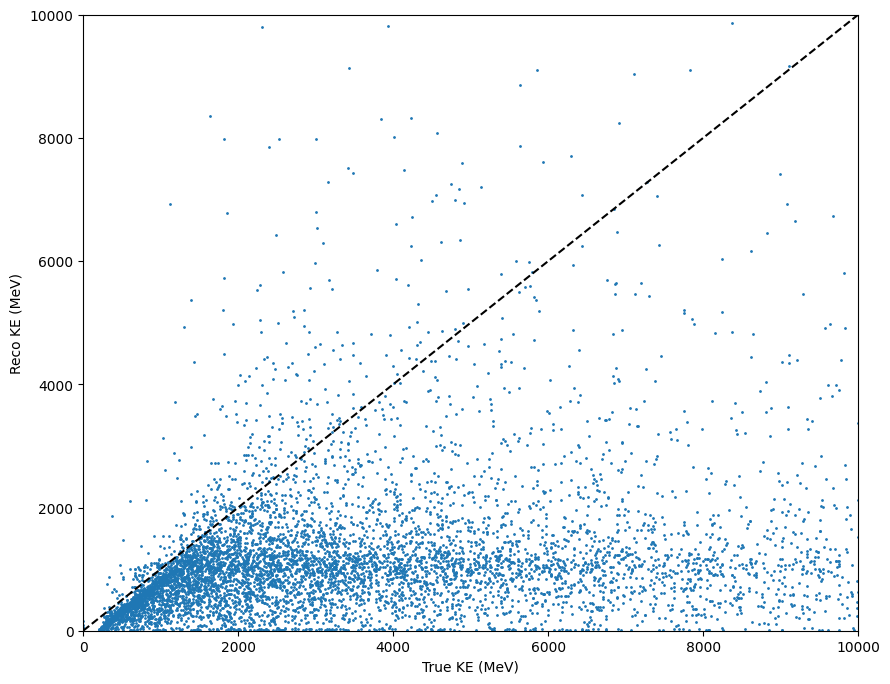

In [7]:
# plot reco energy vs true energy
plt.figure(figsize=(10, 8))
plt.scatter(df['truth_ke'], df['reco_ke'], s=1)
plt.plot([0, 10_000], [0, 10_000], 'k--')
plt.xlim(0, 10_000)
plt.ylim(0, 10_000)
plt.xlabel('True KE (MeV)')
plt.ylabel('Reco KE (MeV)')
plt.show()


In [8]:
with open('/nevis/houston/home/leehagaman/spine/mcs_studies/h5_cosmics_with_segment_angles.pkl', 'wb') as f:
    pickle.dump(df, f)